In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
metadata=pd.read_csv('./archive-3/metadata.csv')
metadata.head()

,FileName,Font,Text
0,file_1.png,CourierNew,Sediment
1,file_2.png,Arial,Guest
2,file_3.png,CenturyGothic,Socket
3,file_4.png,Verdana,Onset
4,file_5.png,Candara,Driver


In [7]:
metadata['Font'].value_counts()

Font
CourierNew         1000
Arial              1000
Bookman            1000
MS_Sans_Serif      1000
MonotypeCorsiva    1000
SegoeUI            1000
TrebuchetMS        1000
LucidaSans         1000
FranclinGothic     1000
Georgia            1000
Helvetica          1000
Lobster            1000
Calibri            1000
Palatino           1000
Garamond           1000
TimesNewRoman      1000
Candara            1000
Verdana            1000
CenturyGothic      1000
ComicSansMS        1000
Name: count, dtype: int64

> There are 20 fonts each containing 1000 images

In [8]:
image_directory = './archive-3/files'

# Function to construct image path if the file exists
def get_image_path(file_name):
    file_path = os.path.join(image_directory, file_name)
    return file_path if os.path.exists(file_path) else None

# Apply the function to create the image_path column
metadata['image_path'] = metadata['FileName'].apply(get_image_path)

# Display the updated dataframe
metadata.head()

,FileName,Font,Text,image_path
0,file_1.png,CourierNew,Sediment,./archive-3/files/file_1.png
1,file_2.png,Arial,Guest,./archive-3/files/file_2.png
2,file_3.png,CenturyGothic,Socket,./archive-3/files/file_3.png
3,file_4.png,Verdana,Onset,./archive-3/files/file_4.png
4,file_5.png,Candara,Driver,./archive-3/files/file_5.png


> splitting the dataset into train test and valid

In [9]:
from sklearn.model_selection import train_test_split

train_list = []
test_list = []
val_list = []

for class_label, group in metadata.groupby('Font'):
    # 70-10-20 split
    train, temp = train_test_split(group, test_size=0.3, random_state=42, stratify=group['Font'])
    test, val = train_test_split(temp, test_size=2/3, random_state=42, stratify=temp['Font'])
    
    # Append to the respective lists
    train_list.append(train)
    test_list.append(test)
    val_list.append(val)

# Combine all splits
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)

# Display the number of samples in each split
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Validation set size: {len(val_df)}")

# Verify class distribution in each split
print("Class distribution in Train set:")
print(train_df['Font'].value_counts())
print("\nClass distribution in Test set:")
print(test_df['Font'].value_counts())
print("\nClass distribution in Validation set:")
print(val_df['Font'].value_counts())


Train set size: 14000
Test set size: 2000
Validation set size: 4000
Class distribution in Train set:
Font
Arial              700
Bookman            700
TrebuchetMS        700
TimesNewRoman      700
SegoeUI            700
Palatino           700
MonotypeCorsiva    700
MS_Sans_Serif      700
LucidaSans         700
Lobster            700
Helvetica          700
Georgia            700
Garamond           700
FranclinGothic     700
CourierNew         700
ComicSansMS        700
CenturyGothic      700
Candara            700
Calibri            700
Verdana            700
Name: count, dtype: int64

Class distribution in Test set:
Font
Arial              100
Bookman            100
TrebuchetMS        100
TimesNewRoman      100
SegoeUI            100
Palatino           100
MonotypeCorsiva    100
MS_Sans_Serif      100
LucidaSans         100
Lobster            100
Helvetica          100
Georgia            100
Garamond           100
FranclinGothic     100
CourierNew         100
ComicSansMS        100
Ce

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(df, img_dir, img_size=(64, 64)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['FileName'])  # Görüntü yolunu al
        img = load_img(img_path, target_size=img_size)  # Görüntüyü yükle
        img_array = img_to_array(img) / 255.0  # Normalizasyon
        images.append(img_array)
        labels.append(row['Font'])  # Etiket
    return np.array(images), np.array(labels)

# Görüntüleri yükle
X_train, y_train = load_images(train_df, image_directory)
X_test, y_test = load_images(test_df, image_directory)
X_val, y_val = load_images(val_df, image_directory)

In [19]:
from tensorflow.keras.utils import to_categorical

# Sınıf isimlerini sayısal değerlere dönüştür
class_names = train_df['Font'].unique()
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

# Etiketleri sayısal değerlere dönüştür
y_train = np.array([class_to_idx[cls] for cls in y_train])
y_test = np.array([class_to_idx[cls] for cls in y_test])
y_val = np.array([class_to_idx[cls] for cls in y_val])

# One-hot encoding
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))
y_val = to_categorical(y_val, num_classes=len(class_names))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_no_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model_no_aug.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [21]:
history_no_aug = model_no_aug.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20


2025-01-27 22:51:15.210158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - ETA: 0s - loss: 2.3092 - accuracy: 0.3409

2025-01-27 22:51:22.503206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 8s 15ms/step - loss: 2.3092 - accuracy: 0.3409 - val_loss: 1.1292 - val_accuracy: 0.6127
Epoch 2/20
438/438 [==============================] - 6s 14ms/step - loss: 1.5804 - accuracy: 0.6981 - val_loss: 0.2984 - val_accuracy: 0.9215
Epoch 3/20
438/438 [==============================] - 5s 11ms/step - loss: 1.3398 - accuracy: 0.8294 - val_loss: 0.2962 - val_accuracy: 0.9570
Epoch 4/20
438/438 [==============================] - 5s 11ms/step - loss: 0.9320 - accuracy: 0.8911 - val_loss: 0.3517 - val_accuracy: 0.9540
Epoch 5/20
438/438 [==============================] - 5s 11ms/step - loss: 1.0354 - accuracy: 0.8996 - val_loss: 0.3161 - val_accuracy: 0.9680
Epoch 6/20
438/438 [==============================] - 5s 11ms/step - loss: 1.0107 - accuracy: 0.9186 - val_loss: 0.2494 - val_accuracy: 0.9735
Epoch 7/20
438/438 [==============================] - 5s 11ms/step - loss: 0.9380 - accuracy: 0.9311 - val_loss: 0.3296 - val_accuracy: 0.9803
Epoch 8/20

In [22]:
loss_no_aug, accuracy_no_aug = model_no_aug.evaluate(X_test, y_test)
print(f"Test Accuracy (No Augmentation): {accuracy_no_aug}")

17/63 [=======>......................] - ETA: 0s - loss: 1.2814 - accuracy: 0.9835

2025-01-27 22:53:17.039588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 7ms/step - loss: 1.8042 - accuracy: 0.9845
Test Accuracy (No Augmentation): 0.984499990940094


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Eğitim verisine uygula
datagen.fit(X_train)

In [24]:
model_with_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model_with_aug.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [29]:
history_with_aug = model_with_aug.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100
)

Epoch 1/100
438/438 [==============================] - 7s 16ms/step - loss: 0.6114 - accuracy: 0.8366 - val_loss: 1.5860 - val_accuracy: 0.7590
Epoch 2/100
438/438 [==============================] - 7s 15ms/step - loss: 0.5886 - accuracy: 0.8487 - val_loss: 0.9535 - val_accuracy: 0.8357
Epoch 3/100
438/438 [==============================] - 7s 15ms/step - loss: 0.6562 - accuracy: 0.8397 - val_loss: 0.9502 - val_accuracy: 0.8167
Epoch 4/100
438/438 [==============================] - 7s 15ms/step - loss: 0.5824 - accuracy: 0.8495 - val_loss: 1.0669 - val_accuracy: 0.8023
Epoch 5/100
438/438 [==============================] - 7s 15ms/step - loss: 0.5623 - accuracy: 0.8584 - val_loss: 1.4969 - val_accuracy: 0.7387
Epoch 6/100
438/438 [==============================] - 7s 15ms/step - loss: 0.5739 - accuracy: 0.8575 - val_loss: 0.5283 - val_accuracy: 0.8845
Epoch 7/100
438/438 [==============================] - 7s 16ms/step - loss: 0.5856 - accuracy: 0.8639 - val_loss: 0.6387 - val_accuracy:

In [30]:
loss_with_aug, accuracy_with_aug = model_with_aug.evaluate(X_test, y_test)
print(f"Test Accuracy (With Augmentation): {accuracy_with_aug}")

63/63 [==============================] - 0s 6ms/step - loss: 8.1350 - accuracy: 0.9050
Test Accuracy (With Augmentation): 0.9049999713897705


In [31]:
print(f"Test Accuracy (No Augmentation): {accuracy_no_aug}")
print(f"Test Accuracy (With Augmentation): {accuracy_with_aug}")

Test Accuracy (No Augmentation): 0.984499990940094
Test Accuracy (With Augmentation): 0.9049999713897705


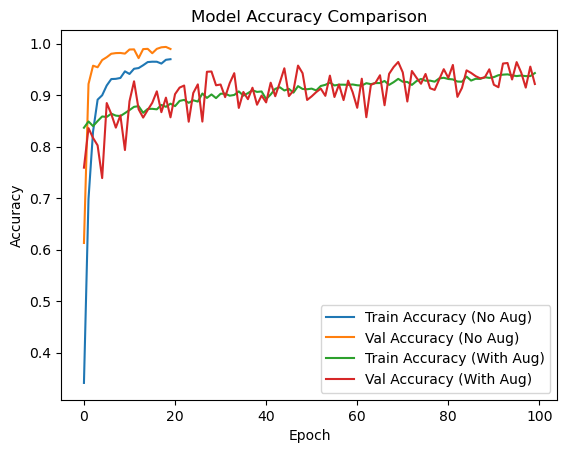

In [32]:
import matplotlib.pyplot as plt

# Doğruluk grafiği
plt.plot(history_no_aug.history['accuracy'], label='Train Accuracy (No Aug)')
plt.plot(history_no_aug.history['val_accuracy'], label='Val Accuracy (No Aug)')
plt.plot(history_with_aug.history['accuracy'], label='Train Accuracy (With Aug)')
plt.plot(history_with_aug.history['val_accuracy'], label='Val Accuracy (With Aug)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()